# Homework 5

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [4]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

In [6]:
def draw_res_matches(pieces, keypoints, good_matches):
    img_res = 0

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                      )
   
    for i in range(len(good_matches)):
        for j, gd_matches in good_matches[i]:
            img_matches = np.empty((max(pieces[i].shape[0], pieces[j].shape[0]), \
                                    pieces[i].shape[1] + pieces[j].shape[1], 3), dtype=np.uint8)
        
            cv2.drawMatches(pieces[i], keypoints[i], pieces[j], keypoints[j], gd_matches, img_matches, **draw_params)
            if type(img_res) == type(img_matches):
                img_res = np.r_[img_res, img_matches]
            else:
                img_res = img_matches
            
        
    plot_one_image(img_res)

In [7]:
def pos_i_piece(pos_pieces, i):
    if not(i in [l[0] for l in pos_pieces]):
        return None
    
    return pos_pieces[([l[0] for l in pos_pieces]).index(i)][1]

In [8]:
def fort_key(x):
    if len(x[1]) == 1:
        return x[1][0].distance
    
#     return sum(sorted([m.distance for m in x[1]])[:2])

    return sum(sorted([m.distance for m in x[1]])[:len(x)//2+1])/(len(x)//2)**2

In [163]:
def draw_res(pieces, keypoints, good_matches):
    
    pos_pieces = [(0, [0, 0])]
    stack = [[0,0]]
    be_done = [0]
    
    while stack != []:     
        i, num_j = stack[-1]
        if num_j > 2:
            stack.pop()
            continue
        
#         temp = sorted(good_matches[i], key=lambda x: len(x[1]))
#         temp = sorted(good_matches[i], key=fort_key)
        temp = sorted(good_matches[i], key=lambda x: min([m.distance for m in x[1]]))
        j = 0
        for j, gd_matches in temp:   
            if pos_i_piece(pos_pieces, j) != None:
                continue
                
            if not len(gd_matches):
                continue
              
            stack[-1][1] += 1
            stack.append([j, 0])
            
            dx = np.zeros([len(gd_matches), 1])
            dy = np.zeros([len(gd_matches), 1])
            for k, gd_matche in enumerate(gd_matches):
                x1, y1 = keypoints[i][gd_matche.queryIdx].pt
                x2, y2 = keypoints[j][gd_matche.trainIdx].pt

                dx[k] = x1 - x2
                dy[k] = y1 - y2

                int_x1, int_y1, int_x2, int_y2 = list(map(int, np.round(np.array([x1, y1, x2, y2]))))
                d_int_x1 = int_x1 if int_x1 > 5 else 0
                d_int_y1 = int_y1 if int_y1 > 5 else 0


            av_dx = dx.mean()
            av_dy = dy.mean()

            ind_y = np.argmin(np.abs(dy-av_dy))
            ind_x = np.argmin(np.abs(dx-av_dx))

            y = int(np.round(dy[ind_y]))
            x = int(np.round(dx[ind_x]))


            x0, y0 = pos_i_piece(pos_pieces, i)
            x += x0
            y += y0

            pos_pieces.append((j, [x,y]))
            break
        else:
            stack.pop()
#             print(i)
            continue
            
        
        

    x_pieces = np.array([l[1][0] for l in pos_pieces])
    y_pieces = np.array([l[1][1] for l in pos_pieces])
    min_x = x_pieces.min()
    max_x = x_pieces.max()
    min_y = y_pieces.min()
    max_y = y_pieces.max()

    sh_piece_max_x = pieces[pos_pieces[np.argmax(x_pieces)][0]].shape
    sh_piece_max_y = pieces[pos_pieces[np.argmax(y_pieces)][0]].shape
    max_x += sh_piece_max_x[1]
    max_y += sh_piece_max_y[0]


    res_im = np.zeros([max_y-min_y, max_x-min_x, 3])
    for i, pos_piece in pos_pieces:
        h, w, _ = pieces[i].shape
        x = pos_piece[0]
        y = pos_piece[1]
        res_im[y - min_y : y - min_y + h, x - min_x : x - min_x + w] = pieces[i]
    print(len(pos_pieces))
    res_im = res_im.astype(np.uint8)
    plot_one_image(res_im)
    return pos_pieces

In [188]:
def my_spec_points(image, max_count=100, ksize=5):
    if not(ksize % 2):
        raise Exception('ksize must be odd (ksize % 2  == 1)')
        
#     h, w, _ = image.shape
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     dst = cv2.cornerMinEigenVal(gray, 5, 5)
#     dst_normed = (dst - dst.min()) / (dst.max() - dst.min())
    
#     dst_normed = np.delete(dst_normed, range(h-1, h-ksize//2-1, -1), 0)  
#     dst_normed = np.delete(dst_normed, range(w-1, w-ksize//2-1, -1), 1)
#     dst_normed = np.delete(dst_normed, range(ksize//2), 1)  
#     dst_normed = np.delete(dst_normed, range(ksize//2), 0)
    
#     dst_normed[dst_normed < 0.02] = 0
    
#     hist, bins = np.histogram(dst_normed.flatten(), 100, [0., 1.0])

    
#     i = 0
#     count = 0
#     for i in range(len(hist)-1,0,-1):
#         count += hist[i]
#         if count > max_count:
#             break
    
    
#     keys = np.argwhere(dst_normed > bins[i+1])
#     if bins[i] != 0:
#         keys2 = np.argwhere((dst_normed > bins[i]) & (dst_normed <= bins[i+1]))[:max_count-len(keys)]
#         keys = np.r_[keys, keys2]
#     keys += ksize//2

    hyp_params = dict(
        nfeatures = 150,
        nOctaveLayers = 8,
        contrastThreshold = 0.01,
        edgeThreshold = 10,
        sigma = 3.0)

#     detector = cv2.xfeatures2d.SIFT_create(**hyp_params)
    detector = cv2.SIFT_create(**hyp_params)
    keypoints, desc = detector.detectAndCompute(image, None)
    
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    desc = np.c_ [desc, np.zeros((desc.shape[0], ksize*ksize*3))]
    for i,key in enumerate(keypoints[:max_count]):
        y, x = np.int32(np.round(key.pt))
        desc[i,-ksize*ksize*3:] = hsv_image[y-ksize//2:y+ksize//2+1, x-ksize//2:x+ksize//2+1].flatten()  
    return keypoints, desc.astype(np.float32)


In [189]:
def puzzle(pieces):
    ratio_thresh = 0.7
    thresh_count = 2
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    descs = []
    keypoints = []
    for im in pieces:
        ki, di = my_spec_points(im)
        descs.append(di)
        keypoints.append(ki)
         
    print([len(l) for l in descs])
    inds_res = []
    good_matches = []
    for i in range(len(descs)):
        good_matches.append([])
        for j in range(len(descs)):
            good_matches[-1].append([j, []])
            desc1 = descs[i]
            desc2 = descs[j]
            
            matches = flann.knnMatch(desc1, desc2, k=2)
            for m, n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_matches[-1][-1][1].append(m)
                    
            if len(good_matches[-1][-1][1]) < thresh_count:
                good_matches[-1].pop()
                
    return draw_res(pieces, keypoints, good_matches)
    

[150, 16, 150, 150, 150, 58, 29, 35]
6


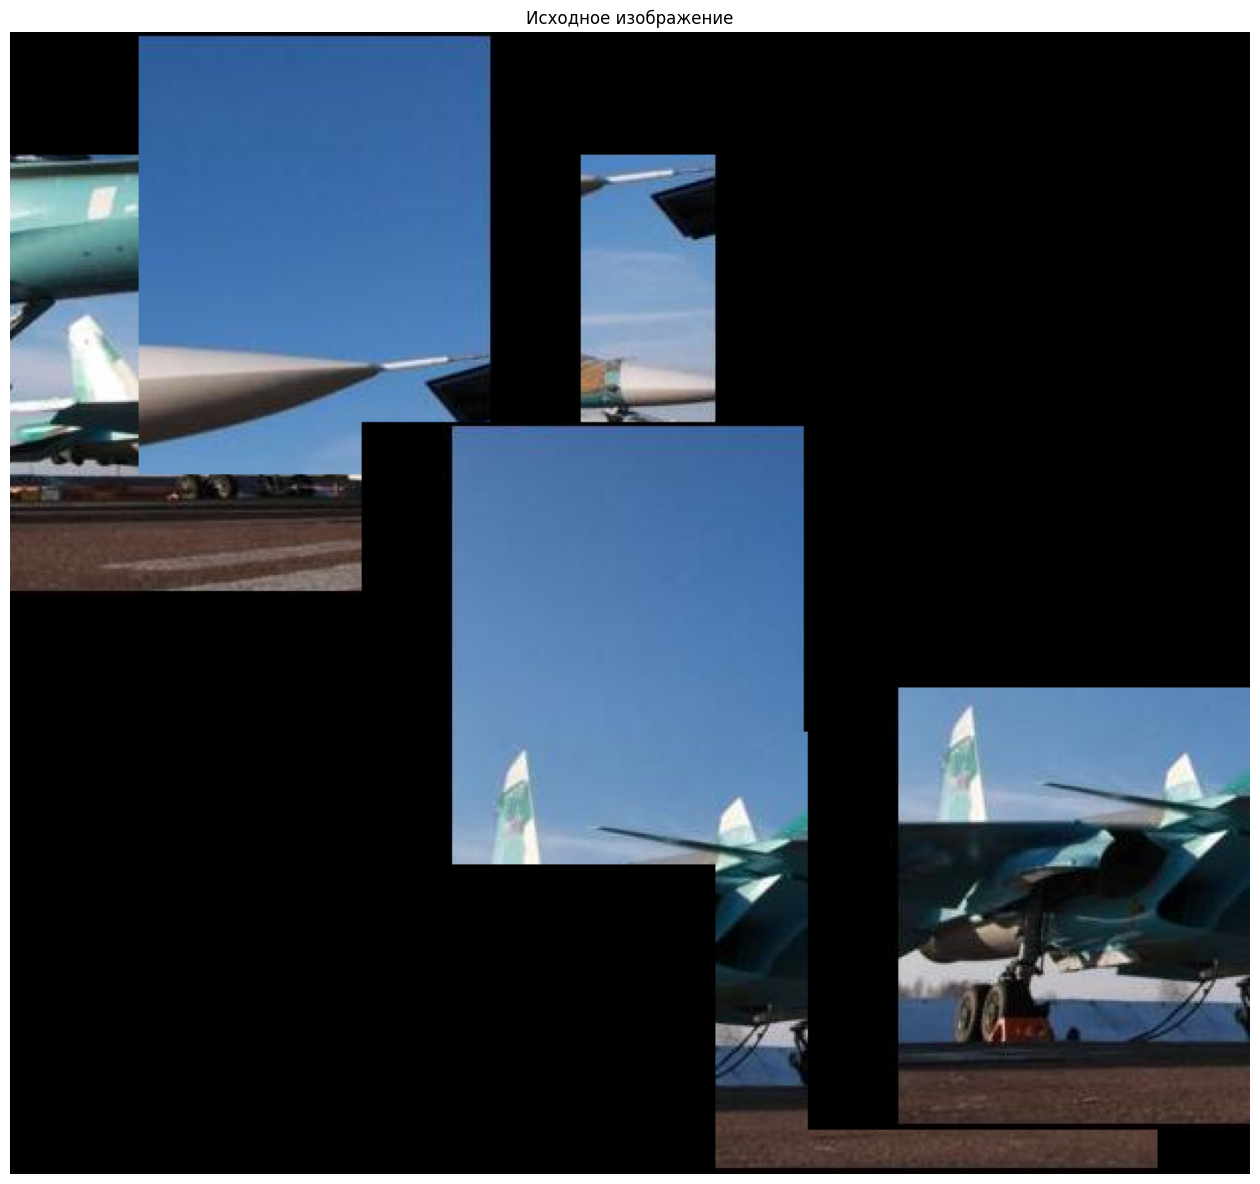

In [191]:
pos_pieces = puzzle(pieces)

In [60]:
def get_puzzle(name_puzzle):
    path = "./puzzle/"+name_puzzle+'/'
    names = os.listdir(path)
    puzzle = []
    for path_im in os.listdir(path):
        puzzle.append(cv2.imread(path+'/'+path_im))
        puzzle[-1] = cv2.cvtColor(puzzle[-1], cv2.COLOR_BGR2RGB)
    return puzzle

In [138]:
pieces = get_puzzle('su_fighter_shuffle')
res_im = cv2.imread("./puzzle/su_fighter.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [14]:
pieces = get_puzzle('china_shuffle')
res_im = cv2.imread("./puzzle/china.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

In [15]:
pieces = get_puzzle('home_shuffle')
res_im = cv2.imread("./puzzle/home.jpg")
res_im = cv2.cvtColor(res_im, cv2.COLOR_BGR2RGB)

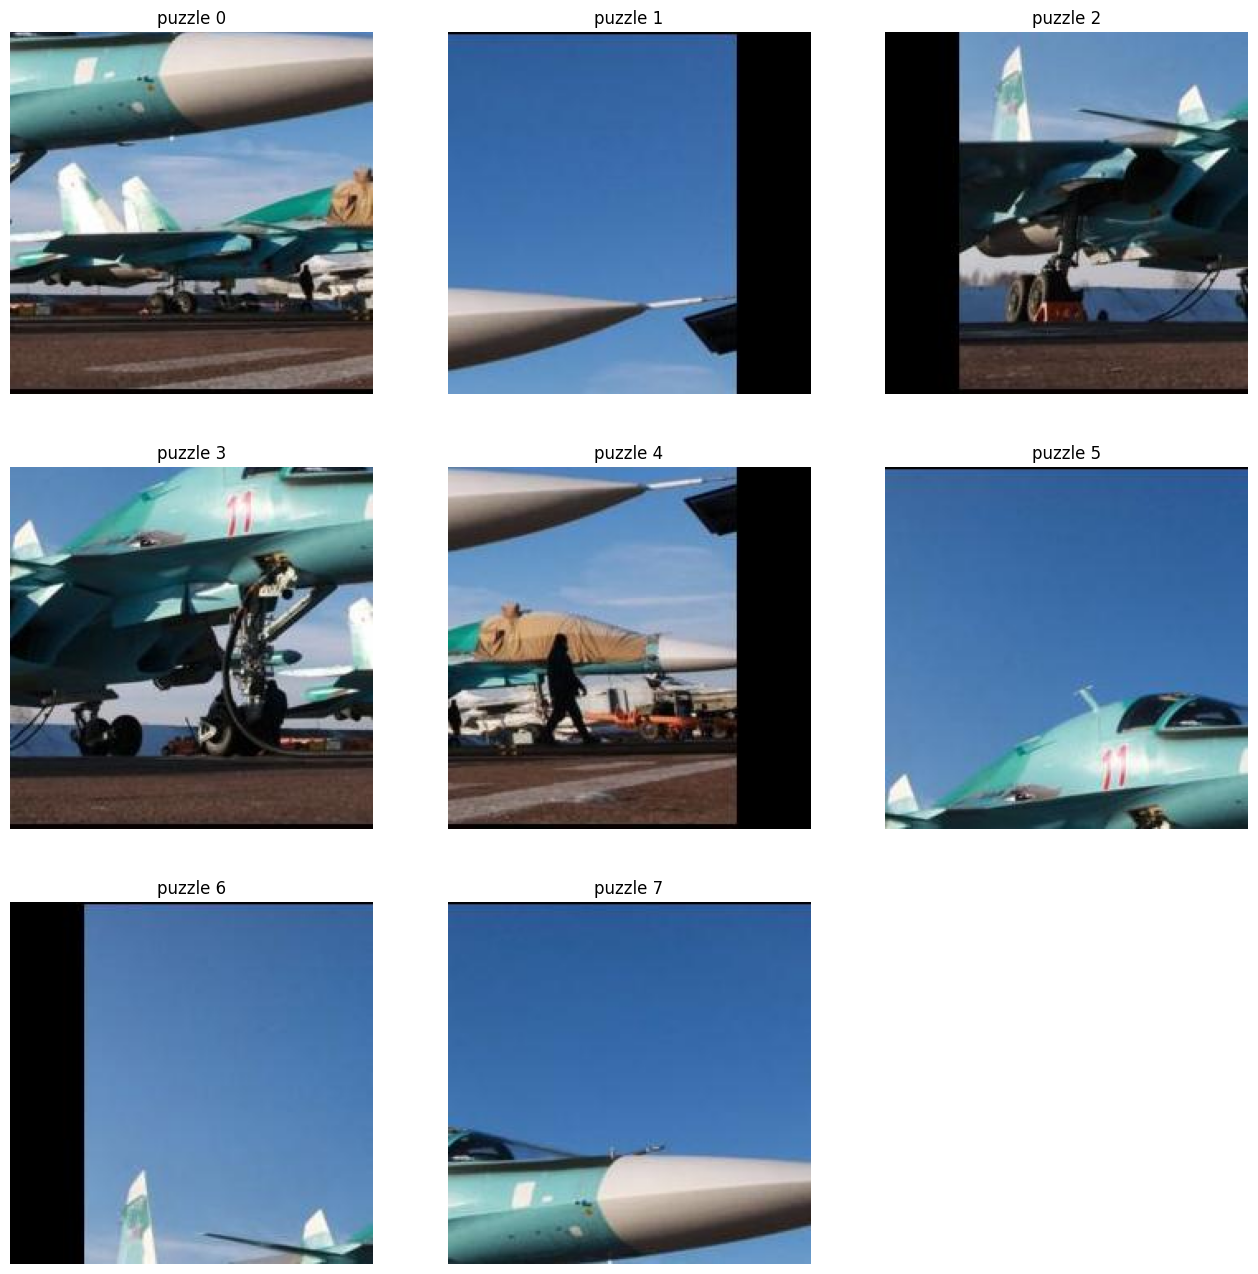

In [139]:
a = int(np.sqrt(len(pieces)))+1
fig, axes = plt.subplots(len(pieces)//a+1, a, figsize=(16, 16))
axes = axes.ravel()

for i in range(len(pieces)):
    axes[i].imshow(pieces[i])
    axes[i].set_title(f'puzzle {i}')
    
for ax in axes:
    ax.axis('off')

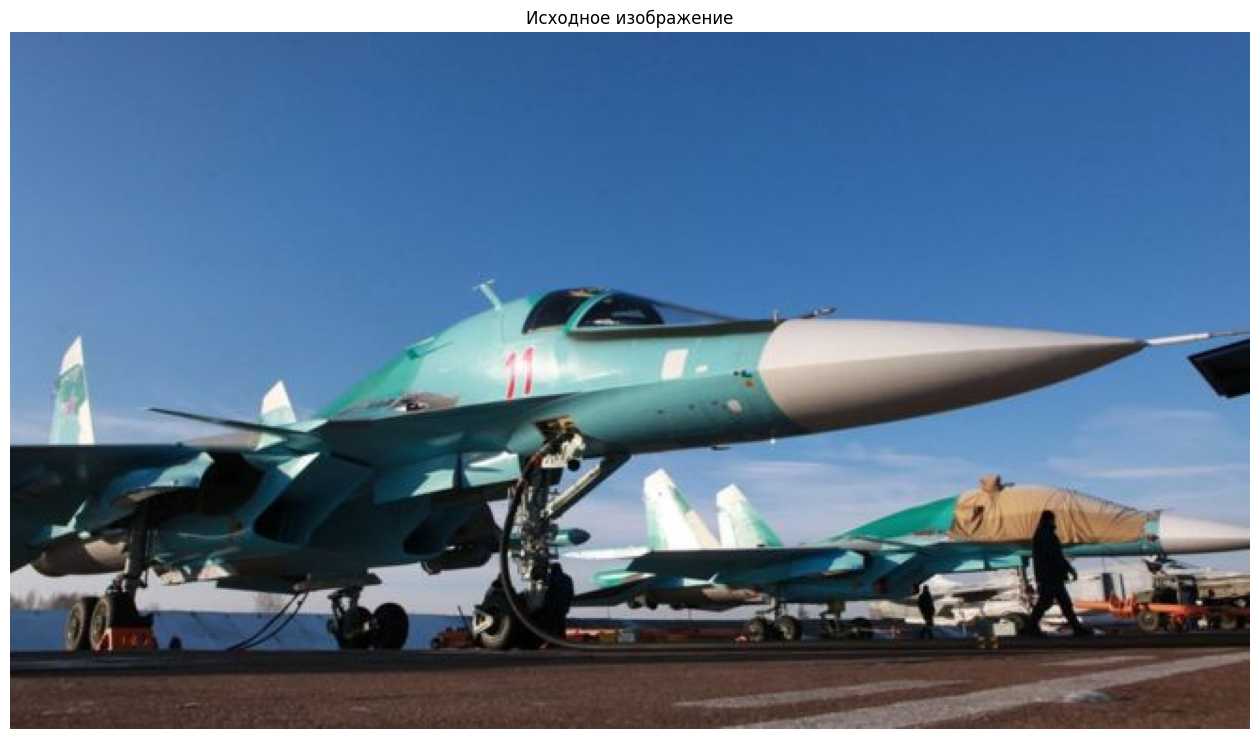

In [140]:
plot_one_image(res_im)